Exploratory analysis of the raw parliamentary data, identifying and removing extraneous parts of the text

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

In [ ]:
df = pd.read_parquet("data/data.parquet")  # path to raw data

In [5]:
df.head()

,Unnamed: 0,speaker,text,party,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,MEP,commission,written,multispeaker,link,translatedText,translationSource,english_text
0,0,President,I wish you an excellent good morning on this l...,-,2024-04-25,2. Interinstitutional Body for Ethical Standar...,1,,NaN,9,True,False,False,False,False,https://www.europarl.europa.eu/doceo/document/...,None,None,I wish you an excellent good morning on this l...
1,1,Daniel Freund,"Frau Präsidentin, liebe Kolleginnen und Kolleg...",Greens/EFA,2024-04-25,2. Interinstitutional Body for Ethical Standar...,2,,6403.0,9,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, dear colleagues! Politics mus...",machine_gm,"Madam President, dear colleagues! Politics mus..."
2,2,Virginijus Sinkevičius,"Madam President, honourable Members, for all o...",-,2024-04-25,2. Interinstitutional Body for Ethical Standar...,3,,NaN,9,False,False,True,False,False,https://www.europarl.europa.eu/doceo/document/...,None,None,"Madam President, honourable Members, for all o..."
3,3,Sven Simon,"Madam President, colleagues, this last day of ...",PPE,2024-04-25,2. Interinstitutional Body for Ethical Standar...,4,,6398.0,9,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, colleagues, this last day of ...",original_gm,"Madam President, colleagues, this last day of ..."
4,4,Gabriele Bischoff,"Frau Präsidentin, werte Kommission, Kolleginne...",S&D,2024-04-25,2. Interinstitutional Body for Ethical Standar...,5,,6399.0,9,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, honourable Commission, collea...",machine_gm,"Madam President, honourable Commission, collea..."


In [4]:
df['english_text'] = df[['text', 'translatedText']].apply(lambda variants: variants['translatedText'] if isinstance(variants['translatedText'], str) else variants['text'] , axis=1)

In [6]:
# exclude president
df = df[~df['speaker'].isin({'Der Präsident',
 'Die Präsidentin',
 'El Presidente',
 'La Présidente',
 'Le Président',
 'Președintele',
 'Talmannen', 'President'})]

In [7]:
df['english_text'].head()

1    Madam President, dear colleagues! Politics mus...
2    Madam President, honourable Members, for all o...
3    Madam President, colleagues, this last day of ...
4    Madam President, honourable Commission, collea...
5    Madam President, Commissioner, it is always an...
Name: english_text, dtype: object

# Common Start of the texts

## Language Flags

In [8]:
import re

language_marks = df['english_text'].apply(lambda txt: (re.findall(r"^\(.+?\)", txt) + [""])[0])

In [9]:
language_marks.value_counts()[language_marks.value_counts() < 10]

english_text
(The speaker speaks without a microphone.)                                     9
(microphone off at start of speech)                                            6
(The speaker intervenes in Catalan.)                                           6
(The first part of the speech was not recorded due to a technical problem.)    6
(...)                                                                          5
                                                                              ..
(Initial words inaudible)                                                      1
(the speaker was far from the microphone)                                      1
(beginning of speech with microphone off)                                      1
(Beginning of intervention off microphone)                                     1
(EL )                                                                          1
Name: count, Length: 188, dtype: int64

In [10]:
language_marks.value_counts()[language_marks.value_counts() > 10].index

Index(['', '(FR)', '(DE)', '(PT)', '(IT)', '(NL)', '(ES)', '(PL)', '(EL)',
       '(RO)', '(SV)', '(LT)', '(FI)', '(SK)', '(HU)', '(CS)', '(DA)', '(BG)',
       '(SL)', '(LV)', '(GA)', '(ET)', '(MT)', '(The speaker spoke Irish)',
       '(HE)', '(inaudible)', '(EN)', '(start of speech off mike)',
       '(start of speech off mic)'],
      dtype='object', name='english_text')

In [11]:
LANGUAGE_MARKERS = set(['(FR)', '(DE)', '(PT)', '(IT)', '(NL)', '(ES)', '(PL)', '(EL)',
       '(RO)', '(SV)', '(LT)', '(FI)', '(SK)', '(HU)', '(CS)', '(DA)', '(BG)',
       '(SL)', '(LV)', '(GA)', '(ET)', '(MT)',
       '(HE)',  '(EN)'])

In [12]:
df['english_text'] = df['english_text'].apply(lambda txt: txt[4:] if txt[:4] in LANGUAGE_MARKERS else txt)

## Other Commentary

In [13]:
def extract_parentheses(text: str, parenthese_chars: str = "()") -> list[str]:
    stack = []
    result = []
    for idx, ch in enumerate(text):
        if ch == parenthese_chars[0]:
            stack.append(idx)

        elif ch == parenthese_chars[1]:
            if stack:
                start = stack.pop()

                if not stack:  # we are only taking outermost parentheses hence check for emptiness
                    result.append(text[start + 1: idx])
    return result


In [14]:
s = "A (B (C) D) E (F(G(H)))"
print(extract_parentheses(s))


['B (C) D', 'F(G(H))']


In [15]:
commentary = df['english_text'].apply(lambda text: extract_parentheses(text))
commentary_brackets = df['english_text'].apply(lambda text: extract_parentheses(text, parenthese_chars="[]"))

In [16]:
len(commentary), len(commentary_brackets)

(541005, 541005)

In [17]:
commentary_brackets.explode().value_counts()

english_text
nbsp                                                                                                              2732
nbsp                                                                                                               616
...                                                                                                                219
…                                                                                                                  114
inaudible                                                                                                           25
                                                                                                                  ... 
2013/2026(INI)                                                                                                       1
(2013/2058)(INI))                                                                                                    1
June 2012                          

In [18]:
exploded_commentary = commentary.explode()
exploded_commentary = exploded_commentary[~exploded_commentary.isna()]


### Speaker

In [19]:
speaker_commentary = exploded_commentary[exploded_commentary.str.lower().str.contains('speaker')]
speaker_commentary.value_counts()[:20]

english_text
The President cut off the speaker                                                                                                    1931
The speaker agreed to take a blue-card question under Rule 149(8)                                                                     783
The speaker agreed to take a blue-card question under Rule 162(8)                                                                     651
The President interrupts the speaker                                                                                                  311
The President cut the speaker off                                                                                                     289
The President cuts off the speaker                                                                                                    269
The speaker agreed to answer a question about the “blue card” procedure under Rule 162(8) of the Rules of Procedure.                  258
The President cut off

In [20]:
len(speaker_commentary)

8912

In [21]:
speaker_commentary.groupby(speaker_commentary.index).agg(lambda commentary: list(commentary))

143       [The President withdraws the floor from the sp...
200                     [The President cut off the speaker]
243       [The speaker released a white dove into the ch...
252       [the President withdraws the right to speak fr...
346       [The speaker said ‘thank you’ in several langu...
                                ...                        
573511                  [The President cut the speaker off]
573808                  [The President cut the speaker off]
573906                  [The President cut the speaker off]
573991                  [The President cut the speaker off]
574061                 [The President cut the speaker off ]
Name: english_text, Length: 8751, dtype: object

In [22]:
non_speaker_commentary = exploded_commentary[~exploded_commentary.str.lower().str.contains('speaker')]
non_speaker_commentary.value_counts()[:20]

english_text
Applause                             12346
EC                                    4671
Christian Democrats                   2495
EU                                    1737
EGF                                   1667
2                                     1571
1                                     1334
End of catch-the-eye procedure         859
3                                      799
SMEs                                   742
MFF                                    622
4                                      572
WTO                                    544
CAP                                    457
Parliament adopted the resolution      444
EEC                                    441
EUSF                                   426
PL                                     412
Article 162                            402
FR                                     384
Name: count, dtype: int64

In [23]:
len(non_speaker_commentary)

137153

In [24]:
microphone_commentary = non_speaker_commentary[non_speaker_commentary.str.lower().str.contains('microphone')]
len(microphone_commentary)

203

In [25]:
non_speaker_commentary = non_speaker_commentary[~non_speaker_commentary.str.lower().str.contains('microphone')]

I couldn't look at every single entry but i scanned them briefly and couldn't find general commentary. I have a hunch that unique bracketed comments should be mainly part of the speech

In [26]:
non_speaker_commentary.value_counts()[non_speaker_commentary.value_counts() == 1].to_csv("data/unique_commentary.csv")

In [27]:
leave_in = non_speaker_commentary.value_counts()[non_speaker_commentary.value_counts() == 1].index
non_speaker_commentary = non_speaker_commentary[~non_speaker_commentary.apply(lambda text: text in leave_in)]

In [28]:
# text inside the parenthesis which is part of the real debate is probably longer, I don't see any comments that might be important to infer the context
short_non_speaker_commentary = non_speaker_commentary[non_speaker_commentary.str.split().str.len() <= 2]
short_non_speaker_commentary.value_counts()

english_text
Applause                  12346
EC                         4671
Christian Democrats        2495
EU                         1737
EGF                        1667
                          ...  
119.82 million                2
116 million                   2
PE 504.467                    2
inaudible interjection        2
sound missing                 2
Name: count, Length: 4950, dtype: int64

In [29]:
long_non_speaker_commentary = non_speaker_commentary[non_speaker_commentary.str.split().str.len() > 2]
long_non_speaker_commentary.value_counts()

english_text
End of catch-the-eye procedure                                                                                                                                                                859
Parliament adopted the resolution                                                                                                                                                             444
Parliament adopted the legislative resolution                                                                                                                                                 303
The oral amendment was accepted                                                                                                                                                               267
End of on-demand interventions                                                                                                                                                                196
                 

In [30]:
applause = long_non_speaker_commentary[long_non_speaker_commentary.str.lower().str.contains('applause')]
applause.value_counts()

english_text
Applause from the right                       166
Applause from the left                        155
Applause from certain quarters                 84
Laughter and applause                          63
Loud and sustained applause                    30
                                             ... 
Applause and shouts                             2
Applause and uproar                             2
Applause from the centre and from the left      2
Loud applause from certain quarters             2
Loud and sustained applause                     2
Name: count, Length: 63, dtype: int64

In [31]:
long_non_speaker_commentary = long_non_speaker_commentary[~long_non_speaker_commentary.str.lower().str.contains('applause')]
long_non_speaker_commentary.value_counts()

english_text
End of catch-the-eye procedure                   859
Parliament adopted the resolution                444
Parliament adopted the legislative resolution    303
The oral amendment was accepted                  267
End of on-demand interventions                   196
                                                ... 
Central European Free Trade Agreement              2
which is not yet the subject of an SAA             2
North East Atlantic Fisheries Commission           2
North-East Atlantic Fisheries Commission           2
in the process of being solved                     2
Name: count, Length: 3185, dtype: int64

In [32]:
parliament = long_non_speaker_commentary[long_non_speaker_commentary.str.lower().str.startswith('parliament')]
parliament.value_counts()

english_text
Parliament adopted the resolution                                                                                   444
Parliament adopted the legislative resolution                                                                       303
Parliament agreed to accept the oral amendment                                                                      129
Parliament adopted the text                                                                                          73
Parliament rejected the request                                                                                      69
                                                                                                                   ... 
Parliament agreed to the request to be referred back to committee.                                                    2
Parliament declared the common position approved as amended                                                           2
Parliament accepted the ora

In [33]:
long_non_speaker_commentary = long_non_speaker_commentary[~long_non_speaker_commentary.str.lower().str.startswith('parliament')]
long_non_speaker_commentary.value_counts()

english_text
End of catch-the-eye procedure                                                                               859
The oral amendment was accepted                                                                              267
End of on-demand interventions                                                                               196
End of reports from the floor                                                                                159
End of interventions under the catch-the-eye procedure                                                       133
                                                                                                            ... 
Bulgaria, Croatia, Cyprus and Romania                                                                          2
and other environment measures                                                                                 2
from the economy to religious policy, from diplomacy to defense, including human ri

In [34]:
end_of = long_non_speaker_commentary[long_non_speaker_commentary.str.lower().str.startswith('end of')]
end_of.value_counts()

english_text
End of catch-the-eye procedure                                        859
End of on-demand interventions                                        196
End of reports from the floor                                         159
End of interventions under the catch-the-eye procedure                133
End of the "catch the eye" procedure                                   95
End of interventions on request                                        95
End of "catch-the-eye" procedure                                       91
End of the "catch the eye" procedure.                                  70
End of "catch the eye" procedure                                       61
End of the catch-the-eye procedure                                     61
End of spontaneous requests to speak                                   60
End of "Catch-the-Eye" process                                         45
End of remarks from the floor                                          33
End of interventions with

In [35]:
long_non_speaker_commentary = long_non_speaker_commentary[~long_non_speaker_commentary.str.lower().str.startswith('end of')]
long_non_speaker_commentary.value_counts()

english_text
The oral amendment was accepted                                                                              267
Explanation of vote abbreviated in accordance with Rule 137(1) of the Rules of Procedure                     128
Ende der spontanen Wortmeldungen                                                                             103
Koniec pytań z sali                                                                                           92
Speaking sessions granted on request end                                                                      85
                                                                                                            ... 
and other environment measures                                                                                 2
from the economy to religious policy, from diplomacy to defense, including human rights and civil society      2
the specialized cancer agency of the World Health Organization                     

In [36]:
vote = long_non_speaker_commentary[long_non_speaker_commentary.str.lower().str.startswith('explanation of vote')]
vote.value_counts()

english_text
Explanation of vote abbreviated in accordance with Rule 137(1) of the Rules of Procedure               128
Explanation of vote abbreviated in accordance with Rule 163(1) of the Rules of Procedure                47
Explanation of vote cut short pursuant to Rule 137(1) of the Rules of Procedure                         36
Explanation of vote abbreviated in accordance with Rule 163 of the Rules of Procedure                   27
Explanation of vote abbreviated in accordance with Rule 170 of the Rules of Procedure                   18
Explanation of vote abbreviated in accordance with Rule 137 (1) of the Rules of Procedure                9
Explanation of vote abbreviated in accordance with Rule 170                                              8
Explanation of vote abbreviated in accordance with Rule 163                                              7
Explanation of vote abbreviated in accordance with Article 137(1) of the Rules of Procedure              7
Explanation of vote abbr

In [37]:
long_non_speaker_commentary = long_non_speaker_commentary[~long_non_speaker_commentary.str.lower().str.startswith('explanation of vote')]
long_non_speaker_commentary.value_counts()

english_text
The oral amendment was accepted                                            267
Ende der spontanen Wortmeldungen                                           103
Koniec pytań z sali                                                         92
Speaking sessions granted on request end                                    85
The oral amendment was not accepted                                         80
                                                                          ... 
the specialized cancer agency of the World Health Organization               2
the assessments would not be completed                                       2
business closures, relocation                                                2
young people without employment, without diplomas and without training       2
in the process of being solved                                               2
Name: count, Length: 3004, dtype: int64

In [38]:
amendment = long_non_speaker_commentary[long_non_speaker_commentary.str.lower().str.startswith('the oral amendment')]
amendment.value_counts()

english_text
The oral amendment was accepted           267
The oral amendment was not accepted        80
The oral amendment is accepted.            63
The oral amendment was adopted             30
The oral amendment was accepted.           25
The oral amendment is not accepted.        16
The oral amendments were accepted          14
The oral amendment was approved            11
The oral amendment was not accepted.       10
The oral amendment was rejected             8
The oral amendment is adopted.              5
The oral amendment was adopted.             5
The oral amendment is reserved              3
The oral amendment is not accepted          3
The oral amendments are accepted.           2
The oral amendment was not considered.      2
The oral amendment was incorporated         2
The oral amendment was allowed              2
The oral amendments were adopted            2
The oral amendment was not allowed          2
The oral amendments were accepted.          2
the oral amendment wa

In [39]:
long_non_speaker_commentary = long_non_speaker_commentary[~long_non_speaker_commentary.str.lower().str.startswith('the oral amendment')]
long_non_speaker_commentary.value_counts()

english_text
Ende der spontanen Wortmeldungen                                           103
Koniec pytań z sali                                                         92
Speaking sessions granted on request end                                    85
The President declared the common position approved as amended              77
holders of ordinary, diplomatic, service/official and special passports     63
                                                                          ... 
the assessments would not be completed                                       2
business closures, relocation                                                2
young people without employment, without diplomas and without training       2
“Repair and installation of machinery and equipment”                         2
in the process of being solved                                               2
Name: count, Length: 2982, dtype: int64

In [40]:
president = long_non_speaker_commentary[long_non_speaker_commentary.str.lower().str.startswith('the president')]
president.value_counts()

english_text
The President declared the common position approved as amended                                 77
The President established that there were no objections to the oral amendment                  48
The President declared the common position approved                                            36
The president interrupted the representative.                                                  23
The President cut off the Member's floor                                                       22
The President declared the common position approved (as amended)                                8
The President noted that there was no opposition to considering the oral amendment              8
the president interrupted the representative                                                    8
The President noted that there was no opposition to the oral amendment                          7
The President interrupted the representative.                                                   5
The Pre

In [41]:
long_non_speaker_commentary = long_non_speaker_commentary[~long_non_speaker_commentary.str.lower().str.startswith('the president')]
long_non_speaker_commentary.value_counts()

english_text
Ende der spontanen Wortmeldungen                                           103
Koniec pytań z sali                                                         92
Speaking sessions granted on request end                                    85
holders of ordinary, diplomatic, service/official and special passports     63
ordinary, diplomatic, service/official and special passport holders         59
                                                                          ... 
the report leaves it to the Commission to fight against monopolies           2
unless costs are externalized                                                2
International Trade and Services Agreement                                   2
application from Sweden - EGF/2016/002 SE/Ericsson                           2
in the process of being solved                                               2
Name: count, Length: 2946, dtype: int64

In [42]:
articles = long_non_speaker_commentary[long_non_speaker_commentary.str.lower().str.startswith('article')]
articles.value_counts()

english_text
Article 162 of the Rules of Procedure                                  44
Article 162 of the Regulation                                          12
Article 163 of the Rules of Procedure                                   7
Article 42 (6) of the Treaty on the European Union                      7
Article 290 TFEU                                                        6
Article 174 TFEU                                                        5
Article 174 of the EU Treaty                                            5
Articles 290 and 291 TFEU                                               5
Article 290 of the Treaty on the Functioning of the European Union      5
Article 42(7) TEU                                                       5
Article XXIV(6) of the GATT 1994                                        4
Article 16 TFEU                                                         4
Article 36 TEU                                                          4
Article 162 GO           

In [43]:
long_non_speaker_commentary = long_non_speaker_commentary[~long_non_speaker_commentary.str.lower().str.startswith('article')]
long_non_speaker_commentary.value_counts()

english_text
Ende der spontanen Wortmeldungen                                                                                                  103
Koniec pytań z sali                                                                                                                92
Speaking sessions granted on request end                                                                                           85
holders of ordinary, diplomatic, service/official and special passports                                                            63
ordinary, diplomatic, service/official and special passport holders                                                                59
                                                                                                                                 ... 
G2/12 and G2/13                                                                                                                     2
which would ensure that, for example, farmers wou

In [44]:
rule = long_non_speaker_commentary[long_non_speaker_commentary.str.lower().str.startswith('rule')]
rule.value_counts()

english_text
Rule 162(8) of the Rules of Procedure                             4
Rule 163 of the Rules of Procedure                                4
Rule 7 of its Rules of Procedure and Protocol No 7 to the TFEU    4
Rule 149(8) of the Rules of Procedure                             3
Rule 153a of the Rules of Procedure                               2
Name: count, dtype: int64

In [45]:
long_non_speaker_commentary = long_non_speaker_commentary[~long_non_speaker_commentary.str.lower().str.startswith('rule')]
long_non_speaker_commentary.value_counts()

english_text
Ende der spontanen Wortmeldungen                                                                                                  103
Koniec pytań z sali                                                                                                                92
Speaking sessions granted on request end                                                                                           85
holders of ordinary, diplomatic, service/official and special passports                                                            63
ordinary, diplomatic, service/official and special passport holders                                                                59
                                                                                                                                 ... 
G2/12 and G2/13                                                                                                                     2
which would ensure that, for example, farmers wou

In [46]:
rule_contains = long_non_speaker_commentary[long_non_speaker_commentary.str.lower().str.contains('rule 1')]
rule_contains.value_counts()

english_text
Abbreviated in accordance with Rule 137(1) of the Rules of Procedure                             26
Abbreviated in accordance with Rule 170 of the Rules of Procedure                                 7
Speech cut short pursuant to Rule 137 of the Rules of Procedure                                   7
Abbreviated in accordance with Rule 163(1) of the Rules of Procedure                              6
Text abbreviated in accordance with Rule 137(1) of the Rules of Procedure                         5
Written statement abbreviated in accordance with Rule 120(7) of the Rules of Procedure            4
Intervention shortened pursuant to Rule 137 of the Rules of Procedure                             3
Speech cut short pursuant to Rule 137(1) of the Rules of Procedure                                3
Speech shortened pursuant to Rule 137(1) of the Rules of Procedure                                2
Text cut short pursuant to Rule 137(1) of the Rules of Procedure                       

In [47]:
long_non_speaker_commentary = long_non_speaker_commentary[~long_non_speaker_commentary.str.lower().str.contains('rule 1')]
long_non_speaker_commentary.value_counts()

english_text
Ende der spontanen Wortmeldungen                                                                                      103
Koniec pytań z sali                                                                                                    92
Speaking sessions granted on request end                                                                               85
holders of ordinary, diplomatic, service/official and special passports                                                63
ordinary, diplomatic, service/official and special passport holders                                                    59
                                                                                                                     ... 
and not in democratic deepening                                                                                         2
regional, national and European                                                                                         2
adaptabilit

In [48]:
speaking_session = long_non_speaker_commentary[long_non_speaker_commentary.str.lower().str.contains('speaking session')]
speaking_session.value_counts()

english_text
Speaking sessions granted on request end    85
Name: count, dtype: int64

In [49]:
long_non_speaker_commentary.value_counts()[long_non_speaker_commentary.value_counts() > 100]

english_text
Ende der spontanen Wortmeldungen    103
Name: count, dtype: int64

In [50]:
long_non_speaker_commentary.value_counts()[(long_non_speaker_commentary.value_counts() > 50) & (long_non_speaker_commentary.value_counts() <= 100)]

english_text
Koniec pytań z sali                                                        92
Speaking sessions granted on request end                                   85
holders of ordinary, diplomatic, service/official and special passports    63
ordinary, diplomatic, service/official and special passport holders        59
according to 2015 figures                                                  52
Name: count, dtype: int64

In [51]:
len(long_non_speaker_commentary)

10730

In [52]:
long_non_speaker_commentary.value_counts()[(long_non_speaker_commentary.value_counts() > 20) & (long_non_speaker_commentary.value_counts() <= 50)]

english_text
estimated at 2 billion at the end of 2016                                                                     49
minus 10 billion                                                                                              48
For the results of the votes and other details concerning them: see Minutes                                   47
start of speech off mic                                                                                       35
The sitting was suspended for a few moments                                                                   34
holders of ordinary, diplomatic, service, official or special passports                                       33
General Fisheries Commission for the Mediterranean                                                            32
holders of an ordinary, diplomatic, service, official or special passport                                     30
organized crime, money laundering, drug trafficking, etc.                          

In [53]:
results = pd.concat([speaker_commentary, microphone_commentary, short_non_speaker_commentary, 
            applause, parliament, end_of, vote, amendment, president, articles,
            rule, rule_contains, speaking_session])

In [54]:
commentary = results.groupby(results.index).agg(lambda comments: list(comments))

In [55]:
commentary.name = 'commentary'

In [56]:
commentary

47                         [End of catch-the-eye procedure]
51                                                    [CCS]
66                                     [Sustained applause]
98                                                      [4]
143       [The President withdraws the floor from the sp...
                                ...                        
574103                            [Loud applause, Applause]
574104                                           [Applause]
574107                                           [Applause]
574108                                          [Applause ]
574110                                           [Applause]
Name: commentary, Length: 72999, dtype: object

In [57]:
merged = pd.merge(df, commentary, left_index=True, right_index=True, how='left')

In [58]:
len(merged), len(df)

(541005, 541005)

In [59]:
merged[~merged['commentary'].isna()]

,Unnamed: 0,speaker,text,party,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,MEP,commission,written,multispeaker,link,translatedText,translationSource,english_text,commentary
47,47,Mick Wallace,"Madam President, when we talk about EU enlarge...",The Left,2024-04-25,3. Pre-enlargement reforms and policy reviews ...,28,,6402.0,9,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, when we talk about EU enlarge...",original_gm,"Madam President, when we talk about EU enlarge...",[End of catch-the-eye procedure]
51,51,Christian Ehler,"Frau Präsidentin, liebe Kolleginnen und Kolleg...",PPE,2024-04-25,4. Framework of measures for strengthening Eur...,2,bill_165_ID bill_195_ID bill_165_ID bill_195_ID,6398.0,9,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, dear colleagues! Today marks ...",machine_gm,"Madam President, dear colleagues! Today marks ...",[CCS]
66,66,Jerzy Buzek,"Mr President, dear Commissioner, dear friends,...",PPE,2024-04-25,4. Framework of measures for strengthening Eur...,17,bill_165_ID bill_195_ID bill_165_ID bill_195_ID,6398.0,9,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Mr President, dear Commissioner, dear friends,...",machine_gm,"Mr President, dear Commissioner, dear friends,...",[Sustained applause]
98,98,Sven Simon,"Madam President, colleagues, the last day of o...",PPE,2024-04-25,7.5. Interinstitutional Body for Ethical Stand...,1,,6398.0,9,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, colleagues, the last day of o...",original_gm,"Madam President, colleagues, the last day of o...",[4]
143,143,François-Xavier Bellamy,"Monsieur le Président, même si se confirme la ...",PPE,2024-04-24,"3. Iran’s unprecedented attack against Israel,...",40,,6398.0,9,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Mr President, even if the de-escalation we all...",machine_gm,"Mr President, even if the de-escalation we all...",[The President withdraws the floor from the sp...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574103,574103,Hans-Gert Pöttering,"(DE) Honoured Madam President, I should like t...",PPE-DE,1999-07-20,3. Election of the President,13,,6398.0,5,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"(DE) Honoured Madam President, I should like t...",original_pl,"Honoured Madam President, I should like to co...","[Loud applause, Applause]"
574104,574104,Enrique Barón Crespo,"(FR) Madam President, I hope you do not mind i...",PSE,1999-07-20,3. Election of the President,14,,6399.0,5,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"(FR) Madam President, I hope you do not mind i...",original_pl,"Madam President, I hope you do not mind if I ...",[Applause]
574107,574107,Francis Wurtz,"(FR) Madam President, I too would like to cong...",GUE/NGL,1999-07-20,3. Election of the President,17,,6402.0,5,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"(FR) Madam President, I too would like to cong...",original_pl,"Madam President, I too would like to congratu...",[Applause]
574108,574108,Gerry Collins,"Madam President, I extend my congratulations a...",UEN,1999-07-20,3. Election of the President,18,,8760.0,5,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, I extend my congratulations a...",original_pl,"Madam President, I extend my congratulations a...",[Applause ]


In [60]:
def remove_from_text(original: str, strings_to_remove: list[str]) -> str:
    print(original)
    for to_remove in strings_to_remove:
        original = original.replace(f"({to_remove})", "")
        original = original.replace(f"[{to_remove}]", "")
    print(original)
    return original

In [63]:
from scripts.preprocessing.remove_commentary import remove_commentary
df = remove_commentary(df, text_column='english_text')

# Greetings

In [141]:
from tqdm import tqdm
from collections import defaultdict

def get_doc_frequencies(series):
    word_doc_freq = defaultdict(int)
    for unique_words in tqdm(series.str.lower().str.split().iloc):
        for word in set(unique_words):
            word_doc_freq[word] += 1
    doc_freq = pd.DataFrame(word_doc_freq.items(), columns=['term', 'doc_freq'])
    doc_freq['prct'] = doc_freq['doc_freq'] / len(series) * 100
    return doc_freq.sort_values(by='prct', ascending=False)


In [142]:
corpus_doc_freq = get_doc_frequencies(df['english_text'])

541005it [00:31, 16908.83it/s]


In [ ]:
corpus_doc_freq[corpus_doc_freq['prct'] > 25]

,term,doc_freq,prct
0,but,199120,36.805575
5,all,189648,35.054759
7,must,170536,31.522075
18,we,290172,53.635733
20,the,534095,98.722747
37,by,276267,51.065517
63,it,359183,66.391808
68,for,434375,80.290385
76,would,157124,29.042985
83,a,455067,84.115119


## First couple of words

In [64]:
greetings = df['english_text'].apply(lambda txt: " ".join(txt.split()[:9]))

In [68]:
# A lot of voting explanation, one can see that there is a lot of superflous wording and repeating patterns
greetings.value_counts()[greetings.value_counts() > 200]

english_text
I voted in favor of                       19786
Mr President, ladies and gentlemen,       13823
I voted in favour of                      13746
Mr President, I would like                 5675
Madam President, ladies and gentlemen,     4725
                                          ...  
Madam President, I voted in                 212
Madam President, honourable Members, I      209
Mr President, I welcome this                206
Mr President, allow me to                   205
This motion for a resolution                202
Name: count, Length: 113, dtype: int64

In [66]:
greetings = df['english_text'].apply(lambda txt: " ".join(txt.split()[:5]))

In [67]:
greetings.value_counts()[greetings.value_counts() > 200][0:20]

english_text
I voted in favor of                          19786
Mr President, ladies and gentlemen,          13823
I voted in favour of                         13746
Mr President, I would like                    5675
Madam President, ladies and gentlemen,        4725
Mr President, Commissioner, ladies and        4304
Madam President, I would like                 2514
I voted for this report                       1855
Mr President, I should like                   1782
I have voted in favor                         1737
I voted for the report                        1337
Madam President, Commissioner, ladies and     1261
I voted against this report                   1129
Mr President, I wish to                        988
Today I voted in favor                         881
I have voted in favour                         847
Mr President, first of all                     830
Mr President, Mr President-in-Office of        777
Mr President, first of all,                    773
. — I voted in    

In [138]:
GREETINGS = [ "Mr President, ladies and gentlemen", 
                 "Mr President, Mr President-in-Office of the Council",
                 "Mr President, Commissioner, ladies and gentlemen",
                  "Madam President, ladies and gentlemen,",
                  "Madam President, dear colleagues!",
                  "Madam President, honourable Members,",
                  "Madam President, colleagues",
                  "Madam President, Commissioner",
                 "Mr President, first of all,",
                 "Mr President, Commissioner,",
                 "Mr President,",
                 "Madam President" ]

In [61]:
greetings[~(greetings.str.startswith("I voted in favor of") | greetings.str.startswith("I voted in favour of"))].value_counts()[3:]

english_text
I have voted in favor of                                   1703
Madam President, I would like to                           1663
(DE) Mr President, Commissioner, ladies and                1393
(FR) I voted in favour of                                  1323
(LT) I voted in favour of                                  1298
                                                           ... 
I think that recently both Serbia                             1
In connection with the EU report                              1
Madam President, the continuation of Serbia's                 1
Madam President, Commissioner, relations between Serbia       1
(DE) Madam President, if you continue                         1
Name: count, Length: 326540, dtype: int64

## Greetings as first sentence
A better way of cathing patterns, look sentence wise

In [69]:
cleaned = df[df['english_text'].str.len() != 0]

In [70]:
import nltk
first_sentence = cleaned['english_text'].apply(lambda txt: nltk.sent_tokenize(txt)[0])

In [73]:
first_sentence.value_counts()[:20]

english_text
Madam President!                                                                                                                                                                                   5833
.                                                                                                                                                                                                  5652
Mr President!                                                                                                                                                                                      4406
Mister President!                                                                                                                                                                                  3067
Mr. President!                                                                                                                                                                             

In [74]:
len(first_sentence[first_sentence.str.lower().str.contains("president")].value_counts())

208611

In [72]:
first_sentence[first_sentence.str.lower().str.contains("president")].value_counts()[:30]

english_text
Madam President!                                         5837
Mr President!                                            4409
Mister President!                                        3067
Mr. President!                                            844
Mr President, dear colleagues!                            511
Madam President, dear colleagues!                         437
Mr President, Commissioner!                               346
President!                                                324
Madam President, Commissioner!                            322
Thank you, Mr President.                                  299
Mr President, Commissioner, dear colleagues!              285
Madam President, Commissioner, dear colleagues!           248
Mr. President, ladies and gentlemen!                      233
Madam President, ladies and gentlemen!                    200
Mr President, ladies and gentlemen!                       178
Ms. President!                                           

In [74]:
first_sentence[first_sentence.str.lower().str.contains("president")].value_counts()[30:60]

english_text
Madam president.                                        57
Mr President, colleagues!                               55
Mr President, on a point of order.                      52
Dear Madam President!                                   50
Mr President, Madam Commissioner, dear colleagues!      49
Thank you very much, Mr President.                      49
Madam President, esteemed colleagues!                   48
Mr President, esteemed colleagues!                      42
Thank you, Mr. President.                               39
Madam President, Commissioner, colleagues!              38
Madam President, dear Commissioner, dear colleagues!    36
Mr President, Mr Commissioner!                          36
Mr President, I will be very brief.                     35
Mr President, Commissioner, ladies and gentlemen.       34
Thank you Mr President.                                 33
Madam President, honourable colleagues!                 33
Madam President, colleagues!               

In [78]:
first_sentence[first_sentence.str.lower().str.contains("president")].value_counts()[first_sentence[first_sentence.str.lower().str.contains("president")].value_counts() > 2][-30:]

english_text
Thank you very much, Mr President, ladies and gentlemen.                           3
Madam President, honourable Members, Mr.                                           3
Mr. President, I supported this draft report.                                      3
Mr/Madam President, Commissioner, colleagues.                                      3
Mr President, Commissioner, thank you for your reply.                              3
Mr. President, Mrs.                                                                3
Madam President, Madam High Representative!                                        3
Mr President, I should like to congratulate the rapporteur on this report.         3
Madam President, Commissioner, President-in-Office of the Council!                 3
Madam President, I voted in favour.                                                3
Mr. President, Mr. Minister!                                                       3
Mr President, I should like to thank the Members for

In [75]:
# get repeating / non-unique greetings (as unique greetings might involve some relevant information)
greeting_sentence_ft_president = first_sentence[first_sentence.str.lower().str.contains("president")].value_counts()[first_sentence[first_sentence.str.lower().str.contains("president")].value_counts() > 2]

### Not mentioning President

In [76]:
other_greetings = first_sentence[~first_sentence.str.lower().str.contains("president")]
other_greetings.value_counts()[:30]

english_text
.                                                                                                                                                                                                  5652
In favour.                                                                                                                                                                                          820
Mr Speaker!                                                                                                                                                                                         770
I supported.                                                                                                                                                                                        504
Fru talman!                                                                                                                                                                                

In [91]:
other_greetings
thanking = other_greetings[other_greetings.str.lower().str.contains("thank")]

In [96]:
len(thanking.unique())

4625

In [98]:
thanking.value_counts()[thanking.value_counts() > 1]

english_text
Thank you very much.                                                                                                                                43
Thank you, Chairman.                                                                                                                                43
Thank you for the question.                                                                                                                         41
Thank you.                                                                                                                                          34
Thank you for this question.                                                                                                                        31
                                                                                                                                                    ..
Mr. Rübig, thank you very much for this question.                                

### Explaining their vote

In [99]:
voting = other_greetings[other_greetings.str.lower().str.contains("vote")]
len(voting.unique())

68261

In [143]:
voting_term_freq = get_doc_frequencies(voting)

82774it [00:00, 107851.79it/s]


In [147]:
voting_term_freq.head(25)

,term,doc_freq,prct
18,the,72188,87.210960
57,i,70139,84.735545
64,voted,69969,84.530166
17,of,68065,82.229927
22,in,61484,74.279363
78,and,41848,50.556938
27,to,40157,48.514026
50,this,39140,47.285379
63,for,37231,44.979100
59,on,33834,40.875154


In [146]:
corpus_doc_freq.head(25)

,term,doc_freq,prct
20,the,534095,98.722747
246,of,520470,96.204286
129,to,510790,94.415024
118,and,507024,93.718912
252,in,502262,92.838698
83,a,455067,84.115119
204,is,441250,81.561169
68,for,434375,80.290385
237,that,432920,80.021442
112,this,415075,76.722951


In [103]:
words = voting.str.split().explode()

In [104]:
words.value_counts()

english_text
the           244185
of            157936
in             95091
I              82686
voted          70088
               ...  
25.16%             1
360,               1
967                1
rigid              1
willingly.         1
Name: count, Length: 46350, dtype: int64

In [101]:
voting[voting.str.lower().str.contains("because")].value_counts()

english_text
I voted to postpone discharge on this report today because the European Court of Auditors did not give the EU budget as a whole a positive statement of assurance.                                                                                                                                                                                                                                                                                                  51
I voted in favour of this discharge because I am satisfied with the budget performance and monitoring.                                                                                                                                                                                                                                                                                                                                                              46
I voted in favor of this resolution because this European Union agency has ta

In [102]:
non_unique_votings = voting.value_counts()[voting.value_counts() > 1]

In [104]:
non_unique_votings.index

Index(['I voted in favour of this report.', 'I voted for this report.',
       'I voted against.', 'I voted in favour.',
       'UKIP voted against the discharge votes for multiple reasons.',
       'I voted against this report.', 'I voted in favour of the report.',
       'I voted against this text.', 'I voted in favor of this resolution.',
       'UKIP voted against this non-legislative and non-binding report.',
       ...
       'I voted in support of the Stabilisation and Association Agreement between the European Communities and their Member States and the former Yugoslav Republic of Macedonia.',
       'I voted in favor of this report to send a strong signal to the Council.',
       'I voted in favor of the honorable member's proposal.',
       '‒ When voting on the European Parliament's resolution on the European semester for the coordination of economic policies, employment and social aspects in the annual growth survey for 2016, I voted in accordance with the position of the E

In [106]:
common_voting_expl_beginning = voting[voting.isin(non_unique_votings.index)]

In [108]:
common_voting_expl_beginning.str.split().str.len().describe()

count    18379.000000
mean        23.604984
std         18.453119
min          1.000000
25%          7.000000
50%         20.000000
75%         34.000000
max        133.000000
Name: english_text, dtype: float64

<Axes: >

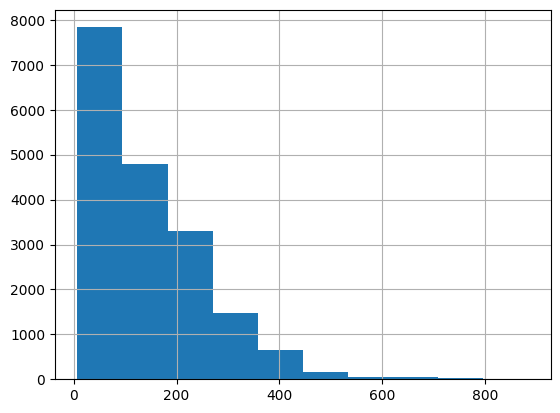

In [110]:
common_voting_expl_beginning.str.len().hist()

In [112]:
common_voting_expl_beginning = common_voting_expl_beginning.apply(lambda txt: txt.split(",")[0] if len(txt.split()) >= 20 else txt)

In [116]:
len(common_voting_expl_beginning.unique())

3522

In [114]:
common_voting_expl_beginning.value_counts()[:30]

english_text
I voted in favour of this report.                                                                                                                                     530
I voted for this report.                                                                                                                                              327
I voted against.                                                                                                                                                      253
I voted in favour.                                                                                                                                                    243
UKIP voted against the discharge votes for multiple reasons.                                                                                                          237
I voted against this report.                                                                                                             

In [115]:
common_voting_expl_beginning.value_counts()[30:60]

english_text
Upvote.                                                                                                                                                                                                                                                                                                                            46
I voted in favour of this discharge because I am satisfied with the budget performance and monitoring.                                                                                                                                                                                                                             46
I will continue to vote against granting discharge for any part of the EU budget until the budget as a whole receives a positive statement of assurance from the Court of Auditors.                                                                                                                                                45
I voted i

### Thanking So.

## Names

In [84]:
import spacy

nlp = spacy.load("en_core_web_trf")
names = first_sentence.iloc[:20].apply(lambda txt: [ent for ent in nlp(txt).ents if ent.label_ == 'PERSON'])

In [88]:
first_sentence.iloc[5]

'Madam\xa0President, we really have to thank Daniel Freund for his persistent efforts to get this interinstitutional agreement in place.'

In [85]:
names

1                      []
2                      []
3                      []
4                      []
5                      []
6      [(Daniel, Freund)]
7     [(Michèle, Rivasi)]
8                      []
9                      []
10                     []
11                     []
12                     []
13                     []
14                     []
15                     []
16                     []
17                     []
18                     []
21                     []
22                     []
Name: english_text, dtype: object

## Explaining their vote

In [59]:
voting_expl = df[df['english_text'].str.startswith("I voted in favor of") | df['english_text'].str.startswith("I voted in favour of")
                 | df['english_text'].str.startswith("I have voted in favor of")]
voting_expl.head()

,Unnamed: 0,speaker,text,party,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,MEP,commission,written,multispeaker,link,translatedText,translationSource,english_text
9307,9307,Benoît Lutgen,J'ai voté en faveur de ce rapport sur le renou...,PPE,2023-10-19,5. Generational renewal in the EU farms of the...,42,,6398.0,9,False,True,False,True,False,https://www.europarl.europa.eu/doceo/document/...,I voted in favour of this report on generation...,machine_gm,I voted in favour of this report on generation...
46699,46699,Tom Vandenkendelaere,Ik heb voor de dringende procedure gestemd zod...,PPE,2021-03-24,17. Preparation of the European Council meetin...,69,,6398.0,9,False,True,False,True,False,https://www.europarl.europa.eu/doceo/document/...,I voted in favour of the urgent procedure so t...,machine_gm,I voted in favour of the urgent procedure so t...
49955,49955,Mihai Tudose,"Am votat pentru cadrul financiar multianual, c...",S&D,2020-12-16,4. Conclusions of the European Council meeting...,92,bill_12887_ID bill_849_ID bill_1057_ID bill_...,6399.0,9,False,True,False,True,False,https://www.europarl.europa.eu/doceo/document/...,I voted in favor of the multiannual financial ...,machine_gm,I voted in favor of the multiannual financial ...
51384,51384,Domènec Ruiz Devesa,He votado a favor del acuerdo alcanzado esta s...,S&D,2020-11-11,20. Multiannual Financial Framework (including...,54,,6399.0,9,False,True,False,True,False,https://www.europarl.europa.eu/doceo/document/...,I voted in favour of the agreement reached thi...,machine_gm,I voted in favour of the agreement reached thi...
69553,69553,Ангел Джамбазки,"Гласувах в подкрепа на този доклад, защото съв...",ECR,2019-01-31,10.5. Annual report on competition policy (A8-...,6,,6400.0,8,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,I voted in favor of this report because it is ...,machine_pl,I voted in favor of this report because it is ...


In [60]:
len(voting_expl)

29518

In [ ]:
voting_expl['agenda'] # all ot of t he agends don't mention voting at all

9307      5. Generational renewal in the EU farms of the...
46699     17. Preparation of the European Council meetin...
49955     4. Conclusions of the European Council meeting...
51384     20. Multiannual Financial Framework (including...
69553     10.5. Annual report on competition policy (A8-...
                                ...                        
550647                                           3. Welcome
556086                                              4. VOTE
558683                                              4. VOTE
563342                                              6. Vote
567890                               7. VOTE (continuation)
Name: agenda, Length: 29518, dtype: object

In [109]:
voting_expl['agenda'].iloc[-1]

'7. VOTE (continuation)'

In [112]:
df[df['agenda'] == voting_expl['agenda'].iloc[-2]]

,Unnamed: 0,speaker,text,party,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,MEP,commission,written,multispeaker,link,translatedText,translationSource,english_text
516194,516194,Marco Pannella,"(IT) Mr President, I take the floor pursuant t...",ALDE,2004-09-14,6. Vote,1,,6401.0,6,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"(IT) Mr President, I take the floor pursuant t...",original_pl,"(IT) Mr President, I take the floor pursuant t..."
516196,516196,Den Dover,"Mr President, I wish to know whether I am allo...",PPE-DE,2004-09-14,6. Vote,3,,6398.0,6,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"Mr President, I wish to know whether I am allo...",original_pl,"Mr President, I wish to know whether I am allo..."
516198,516198,José Ribeiro e Castro,"(PT) I voted in favour, although I remain oppo...",PPE-DE,2004-09-14,6. Vote,5,,6398.0,6,False,True,False,True,False,https://www.europarl.europa.eu/doceo/document/...,"(PT) I voted in favour, although I remain oppo...",original_pl,"(PT) I voted in favour, although I remain oppo..."
516199,516199,José Ribeiro e Castro,(PT) I voted in favour of the Economic and Soc...,PPE-DE,2004-09-14,6. Vote,6,,6398.0,6,False,True,False,True,False,https://www.europarl.europa.eu/doceo/document/...,(PT) I voted in favour of the Economic and Soc...,original_pl,(PT) I voted in favour of the Economic and Soc...
516200,516200,José Ribeiro e Castro,(PT) I voted in favour of the request for cons...,PPE-DE,2004-09-14,6. Vote,7,,6398.0,6,False,True,False,True,False,https://www.europarl.europa.eu/doceo/document/...,(PT) I voted in favour of the request for cons...,original_pl,(PT) I voted in favour of the request for cons...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571440,571440,Jan Andersson,(SV) Emissions from heavy goods vehicles are c...,PSE,1999-11-16,6. Vote,13,bill_8713_ID bill_9042_ID bill_9143_ID bill_...,6399.0,5,False,True,False,True,False,https://www.europarl.europa.eu/doceo/document/...,(SV) Emissions from heavy goods vehicles are c...,original_pl,(SV) Emissions from heavy goods vehicles are c...
571441,571441,Françoise Grossetête,(FR) This proposed amendment of Directive 88/7...,PPE-DE,1999-11-16,6. Vote,14,bill_8713_ID bill_9042_ID bill_9143_ID bill_...,6398.0,5,False,True,False,True,False,https://www.europarl.europa.eu/doceo/document/...,(FR) This proposed amendment of Directive 88/7...,original_pl,(FR) This proposed amendment of Directive 88/7...
571442,571442,Jean-Louis Bernié,"(FR) Mr President, the Chichester report will ...",EDD,1999-11-16,6. Vote,15,bill_8713_ID bill_9042_ID bill_9143_ID bill_...,6404.0,5,False,True,False,False,False,https://www.europarl.europa.eu/doceo/document/...,"(FR) Mr President, the Chichester report will ...",original_pl,"(FR) Mr President, the Chichester report will ..."
571443,571443,Krivine and Vachetta,"(FR) Despite its general title, once the gift ...",GUE/NGL,1999-11-16,6. Vote,16,bill_8713_ID bill_9042_ID bill_9143_ID bill_...,6402.0,5,False,True,False,True,True,https://www.europarl.europa.eu/doceo/document/...,"(FR) Despite its general title, once the gift ...",original_pl,"(FR) Despite its general title, once the gift ..."


In [113]:
print(("\n\n\n" + "=" * 100 + "\n\n\n").join(df[df['agenda'] == voting_expl['agenda'].iloc[-2]]['english_text']))

(IT) Mr President, I take the floor pursuant to Rules 166 and 150 to say that, in my view, we are about to commit a very serious and inexplicable act. As Members of the new Parliament, we are being asked to decide upon our times, places and methods of work for 2005. Obviously, to decide on all that, we would need a draft proposal and the opportunity to discuss it and to table amendments. Now, however, without any debate or discussion, without mentioning Strasbourg or our places of work, we find ourselves having to ratify a timetable drawn up by the last Parliament back in April, when there were different majorities and different historical situations in Europe, and which in fact excludes the ten new Member States and their Members. I therefore believe, Mr President, that the Rules of Procedure have not been observed.




Mr President, I wish to know whether I am allowed to make an explanation of vote.




(PT) I voted in favour, although I remain opposed to not holding plenary sessions

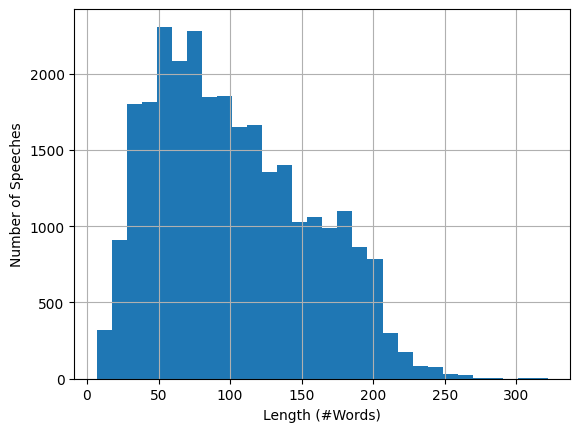

In [48]:
fig, ax = plt.subplots()
lengths = voting_expl['english_text'].str.split().str.len()

ax.hist(lengths, bins=30)
ax.set_ylabel("Number of Speeches")
ax.set_xlabel("Length (#Words)")
ax.grid()

[np.float64(2000.5), np.float64(2001.5), np.float64(2002.5), np.float64(2003.5), np.float64(2005.5), np.float64(2006.5), np.float64(2007.5), np.float64(2008.5), np.float64(2009.5), np.float64(2010.5), np.float64(2011.5), np.float64(2012.5), np.float64(2013.5), np.float64(2014.5), np.float64(2015.5), np.float64(2016.5), np.float64(2017.5), np.float64(2018.5), np.float64(2019.5), np.float64(2020.5), np.float64(2021.5), np.float64(2023.5)]


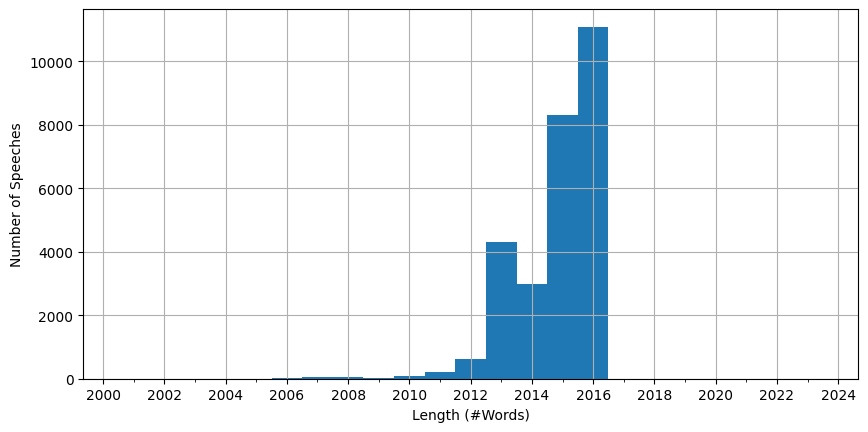

In [47]:

fig, ax = plt.subplots()
fig.set_figwidth(10)
years = pd.to_datetime(voting_expl['date']).dt.year
print([year+0.5 for year in sorted(years.unique())])
ax.hist(years, bins=[year+0.5 for year in sorted(years.unique())])
ax.set_ylabel("Number of Speeches")
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xlabel("Length (#Words)")
ax.grid()

In [89]:
# President Markers identified by the start of the speech
set(df[df['english_text'].str.startswith("The debate is closed. The vote will take place")]['speaker'].unique())

{'Der Präsident',
 'Die Präsidentin',
 'El Presidente',
 'La Présidente',
 'Le Président',
 'Președintele',
 'Talmannen'}

## TF-IDF for not-important sentences

In [148]:
sentence_list = cleaned['english_text'].apply(lambda txt: nltk.sent_tokenize(txt))

In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,       
    max_df=0.99
)
tfidf = vectorizer.fit(sentence_list.explode())


In [168]:
first_sentences = sentence_list.apply(lambda lst: lst[0] if len(lst) else "")

In [ ]:
import numpy as np
X = tfidf.transform(first_sentences)
sentence_scores = np.asarray(X.mean(axis=1)).flatten()

In [191]:
threshold = np.percentile(sentence_scores, 5)
boilerplate_mask = sentence_scores < threshold

In [192]:
first_sentences[boilerplate_mask]

8         Madam President!
63           Mr President!
70           Mr President!
71           Mr President!
72           Mr President!
                ...       
571586      But of course.
571807    Madam President.
573115         Absolutely!
573232                  1.
573575          Thank you.
Name: english_text, Length: 26960, dtype: object

In [202]:
print(first_sentences[boilerplate_mask].sample(n=10))

65503           Mr Speaker!
283808                    .
74960      Madam President!
272146                    .
157237     Madam President!
326565     Madam President!
43104      Madam President!
75578     Mister President!
280159                    .
47918      Madam President!
Name: english_text, dtype: object


### President

In [ ]:
president_subset_mask = first_sentences.str.lower().str.contains("president")

In [ ]:
first_sentence[president_subset_mask].value_counts()[first_sentences[president_subset_mask].value_counts() > 2]

english_text
Madam President!                                                         5833
Mr President!                                                            4406
Mister President!                                                        3067
Mr. President!                                                            844
Mr President, dear colleagues!                                            511
                                                                         ... 
Madam President, dear colleagues, ladies and gentlemen!                     3
Mr President, Honourable Members.                                           3
Madam President, Madam High Representative!                                 3
Mr. President, dear fellow representatives!                                 3
Mr President, Mr Commissioner, Mr President-in-Office of the Council!       3
Name: count, Length: 487, dtype: int64

In [231]:
X_president = tfidf.transform(first_sentence[president_subset_mask].value_counts()[first_sentences[president_subset_mask].value_counts() > 10].index)
freuquent_greetings = np.asarray(X.mean(axis=1)).flatten()

In [232]:
boilerplate_mask = sentence_scores[president_subset_mask] < freuquent_greetings.mean()

In [233]:
len(first_sentences[president_subset_mask][boilerplate_mask]) / len(sentence_scores[president_subset_mask] )

0.49751727956124187

In [234]:
first_sentences[president_subset_mask][boilerplate_mask].value_counts()

english_text
Madam President!                                                                                                                5833
Mr President!                                                                                                                   4406
Mister President!                                                                                                               3067
Mr. President!                                                                                                                   844
Mr President, dear colleagues!                                                                                                   511
                                                                                                                                ... 
Mr President, ladies and gentlemen, although we agree with many passages of this resolution, we have decided not to sign it.       1
Mr President, I support this resolution.                

### Voting

# End of the Debate

In [79]:
endings = df['english_text'].apply(lambda txt: " ".join(txt.split()[-6:]))

In [80]:
endings.value_counts()[endings.value_counts() > 200][3:]

english_text
a blue-card question under Rule 149(8))         743
vote in favor of this report.                   679
a blue-card question under Rule 162(8))         624
162(8) of the Rules of Procedure.)              497
voted in favor of the report.                   448
voted in favour of the report.                  439
a large majority, which I welcome.              435
supported the report with my vote.              322
I therefore voted against this report.          294
of the report with my vote.                     292
(The President cut the speaker off)             268
voted in favor of this resolution.              254
I therefore voted against this text.            251
voted in favor of this text.                    245
vote and in the plenary vote.                   244
(The President cuts off the speaker)            239
engagement which we are principally against.    236
I supported it with my vote.                    234
(The President cut off the speaker.)            203

# Sentences

In [206]:
import nltk
sentences = df['english_text'].apply(nltk.sent_tokenize)

In [209]:
sentences.explode().value_counts()[20:40]

english_text
I voted in favour of this report.                                                                                                                                          512
The primary task of the specialist committee is to ensure and control the regularity and efficiency of the implementation of the community budget.                         508
I supported.                                                                                                                                                               504
Commissioner!                                                                                                                                                              487
Ladies and Gentlemen!                                                                                                                                                      487
Hence my vote in favor.                                                                                         

In [216]:
common_sentences = sentences.explode().value_counts()[sentences.explode().value_counts() > 10]

In [217]:
len(common_sentences)

2418

In [7]:
common_sentences.to_csv("data/common_sentences.csv")

NameError: name 'common_sentences' is not defined

In [17]:
import spacy

nlp = spacy.load("en_core_web_trf")
doc = nlp(df['english_text'].iloc[0])

for ent in doc.ents:
    if ent.label_ == "PERSON":
        print(ent.text)


Qatargate
Katarina Barley
Salvatore De Meo
Qatargate


In [19]:
print(df['english_text'].iloc[0])

Madam President, dear colleagues! Politics must not be for sale. It must not be possible to buy political decisions in this Parliament with a lot of money. Whether Qatar, whether Russia, whether China – especially concerning the extreme right, which is conspicuous by its absence this morning, the AfD, there are now almost daily revelations and arrests. Even below the threshold of criminal law, below bribery, there have been repeated scandals in recent years: conflicts of interest, undeclared side jobs, revolving door cases, undue influence by lobbyists and third countries providing luxury trips to MEPs and Commissioners. The reputation of this House, the reputation of the European Union, has suffered. Dear colleagues, it's clear to most of us: this must finally stop. What's also clear to most is that the rules are less of the problem. The existing rules are quite good, better than in most EU Member States. Lobby meetings and assets must be declared, side jobs in lobbying are prohibited